In [1]:
from sympy import *

In [2]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('japaodez.csv', sep = ',')
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,JPN,Asia,Japan,2020-01-22,2.0,NaN,NaN,NaN,NaN,NaN,...,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.909
1,JPN,Asia,Japan,2020-01-23,2.0,0.0,NaN,NaN,NaN,NaN,...,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.909
2,JPN,Asia,Japan,2020-01-24,2.0,0.0,NaN,NaN,NaN,NaN,...,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.909


In [4]:
nossosdados = pd.concat([df['total_cases'],df['new_cases'],df['total_deaths'],df['new_deaths'],df['population']], axis=1)

In [5]:
nossosdados

,total_cases,new_cases,total_deaths,new_deaths,population
0,2.0,NaN,NaN,NaN,126476458.0
1,2.0,0.0,NaN,NaN,126476458.0
2,2.0,0.0,NaN,NaN,126476458.0
3,2.0,0.0,NaN,NaN,126476458.0
4,4.0,2.0,NaN,NaN,126476458.0
...,...,...,...,...,...
324,175310.0,2904.0,2446.0,51.0,126476458.0
325,178272.0,2962.0,2462.0,16.0,126476458.0
326,180639.0,2367.0,2481.0,19.0,126476458.0
327,182311.0,1672.0,2530.0,49.0,126476458.0


In [6]:
def modelo(xs,t,ps):
    try:
        gamma = ps['gamma'].value 
        mu = ps['mu'].value
        alpha = ps['alpha'].value
        beta = ps['beta'].value
    except:
        gamma, mu, alpha, beta = ps
        
    
    S, E, I, R = xs
    
    return[
        -beta*S*I, 
        beta*S*I - mu*E,
        mu*E - alpha*I - gamma*I,
        alpha*I     
    ]


def engine(t, x0, ps):
    S = 1 - np.sum(x0)
    x0 = np.insert(x0, 0, S)
    x = odeint(modelo, x0, t, args = (ps,))
    return x

In [12]:
#para calcular a fração inicial de infectados no Japão
inicial = nossosdados.loc[0,'total_cases']
fracinicial = inicial/nossosdados.loc[0,'population']

In [13]:
t = np.linspace(0,50,200)
x0 = [0,fracinicial,0]


gamma = 1
mu = 1
alpha = 1
beta = 5

ps = np.array((gamma, mu, alpha, beta))
sol = engine(t,x0,ps)

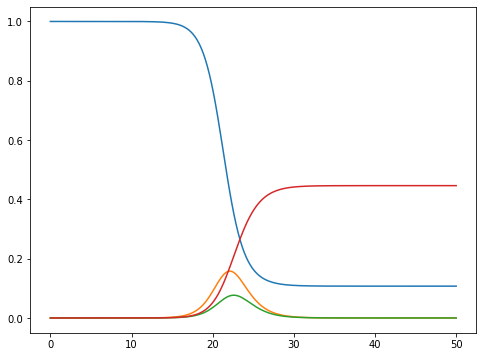

In [14]:
plt.figure(figsize=(8, 6))

for i in range(4):
    plt.plot(t,sol[:,i])

In [17]:
from lmfit import *

In [18]:
def loss(ps, ts, data):
    x0 = ps['E'].value,ps['I'].value,ps['R'].value
    f = engine(ts,x0, ps)
    s = f[:,1]
    return sol[:,1]

In [24]:
params = Parameters()

params.add('E', value=0.0, min=0, max=1,vary= True)
params.add('R', value=0.0, min=0, max=1, vary= True)
params.add('I', value=fracinicial, min=0, max=1, vary= True)
params.add('gamma', value=0, min=0, max=4)
params.add('mu', value=0, min=0, max=1)
params.add('alpha', value=0, min=0, max=1)
params.add('beta', value=0, min=0, max=1)

final = minimize(loss, params, args = (t, dados), method = 'leastsq')

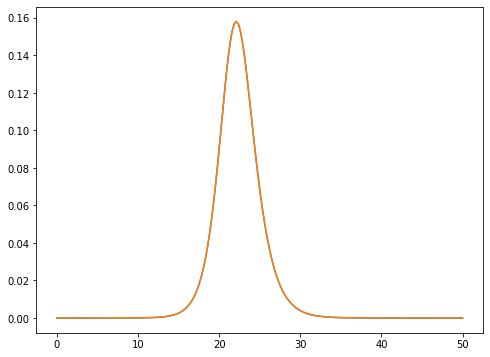

In [25]:
dados = sol[:,1]
plt.figure(figsize=(8, 6))


plt.plot(t, dados)
plt.plot(t, sol[:,1])

In [26]:
report_fit(final)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 200
    # variables        = 7
    chi-square         = 0.37266892
    reduced chi-square = 0.00193093
    Akaike info crit   = -1243.07645
    Bayesian info crit = -1219.98823
##  Warning: uncertainties could not be estimated:
    E:      at boundary
    R:      at boundary
    I:      at initial value
    gamma:  at boundary
    mu:     at boundary
    alpha:  at boundary
    beta:   at boundary
[[Variables]]
    E:      0.00000000 (init = 0)
    R:      0.00000000 (init = 0)
    I:      1.5813e-08 (init = 1.581322e-08)
    gamma:  0.00000000 (init = 0)
    mu:     0.00000000 (init = 0)
    alpha:  0.00000000 (init = 0)
    beta:   0.00000000 (init = 0)


In [16]:
!pip install lmfit

  Created wheel for lmfit: filename=lmfit-1.0.1-cp37-none-any.whl size=82006 sha256=2bd294e6b27d01c1bda1fdf281c6787c0d901be5bb33d4f2cf5b0a9d07f0659b
  Stored in directory: C:\Users\FACC\AppData\Local\pip\Cache\wheels\ef\22\8d\6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.21-cp37-none-any.whl size=17302 sha256=51dabbda9cd3c6e88a29def9cd25a50fe8eaf32e6d5958ab140f8517887c661b
  Stored in directory: C:\Users\FACC\AppData\Local\pip\Cache\wheels\53\9d\3b\da1ff15feb7d97bb195837f4e78f971c748a945bd4720003ce
Successfully built lmfit asteval
